In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn

from IFdensity.contam_sm_de import *
from IFdensity.influence_function import *

from IPython.display import Markdown as md

In [2]:
os.chdir('/Users/chenxizhou/Dropbox/code_package/IFdensity')
true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)

# original data with 108.0 removed 
data_waiting = df[df != 108.0]

# bandwidth parameter in the Gaussian kernel function
bw = 5.0

# penalty parameter 
log_pen_param = -12.0

# base density 
base_density = BasedenGamma(np.load('data/geyser.npy').astype(np.float64)[:, 0])

plot_kwargs = plot_IF_1d_params(x_limit=(21., 410.))

In [13]:
np.sort(np.unique(data_waiting.flatten())).shape

(51,)

In [6]:
data_waiting_pur = data_waiting.flatten() + np.random.randn(len(data_waiting)) / 10.
data_waiting_pur

array([79.83312645, 71.04981682, 57.00659829, 80.14252735, 74.92871655,
       76.82902073, 60.03531435, 85.97758593, 77.03333613, 56.00512921,
       81.02413593, 50.23899102, 89.00925841, 53.84562625, 90.06110082,
       72.9668279 , 60.07228365, 82.98011868, 65.14023751, 82.02941727,
       83.98575836, 53.96697235, 84.98634646, 58.0175307 , 78.90063221,
       56.9671577 , 87.90584911, 67.89931508, 76.06615195, 78.12971181,
       74.05838093, 84.83436316, 74.98940185, 64.88614926, 75.95289888,
       58.02110816, 90.99100628, 49.90185736, 86.99908768, 47.88368305,
       92.98350429, 54.0303972 , 85.99645353, 53.06993541, 78.02661782,
       51.96060249, 82.94439864, 59.84769611, 87.11107007, 48.8777419 ,
       80.04025397, 60.07541349, 92.03845309, 42.89418527, 89.01262213,
       59.87724885, 84.06699498, 69.08388059, 73.88886135, 71.04461362,
       50.18898675, 77.06175185, 57.0369709 , 79.90698606, 60.99390321,
       82.05529091, 47.72106433, 81.18852175, 72.94663344, 61.95

In [8]:
np.max(np.abs(data_waiting - data_waiting_pur))

0.3429841558030091

--------------------------------------------------
Current contaminated data point is 45.0.


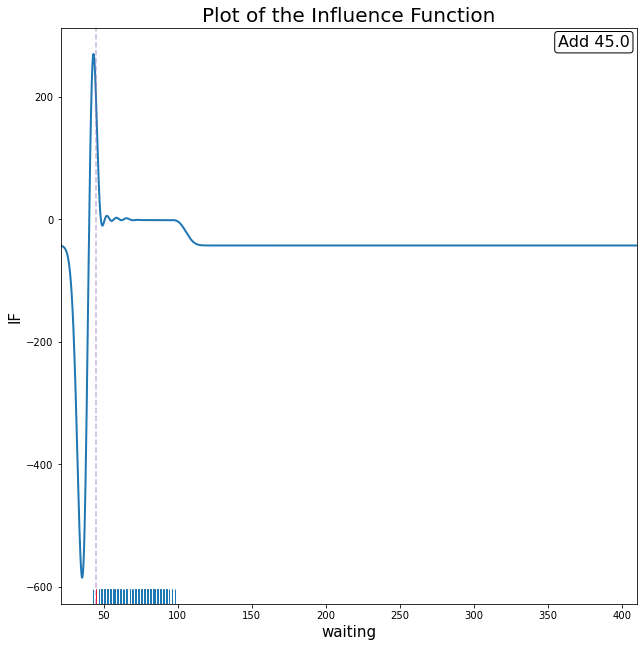

--------------------------------------------------
Current contaminated data point is 96.0.


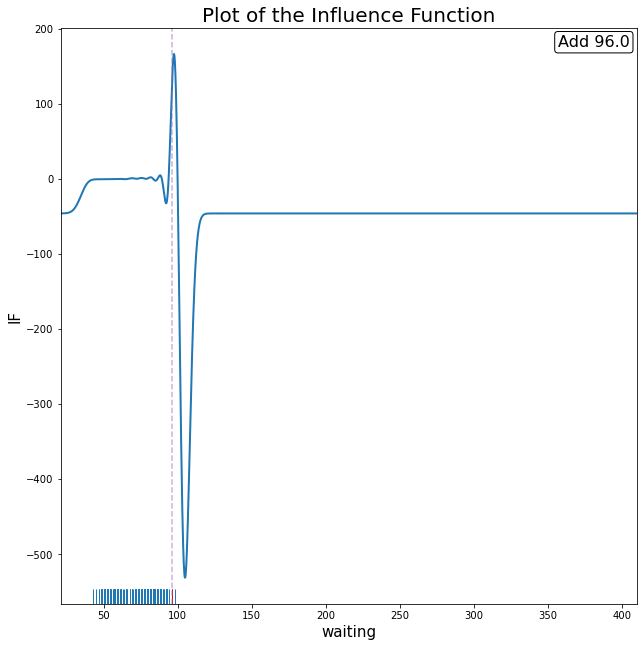

--------------------------------------------------
Current contaminated data point is 78.0.


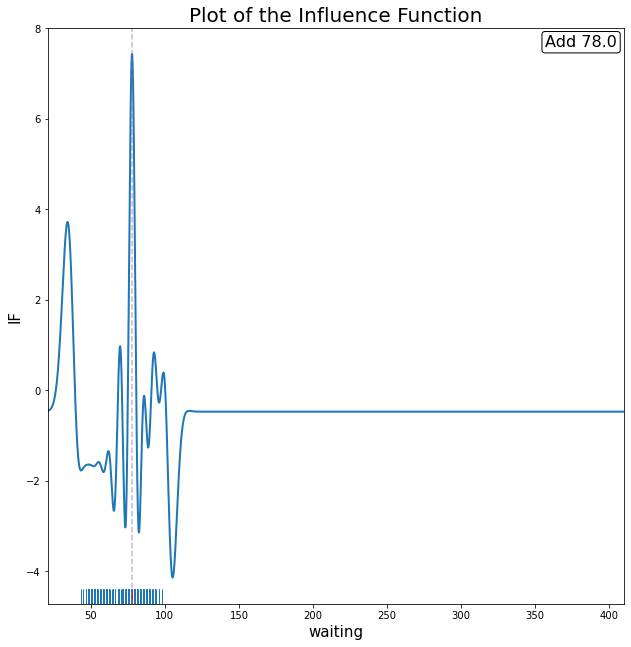

--------------------------------------------------
Current contaminated data point is 70.0.


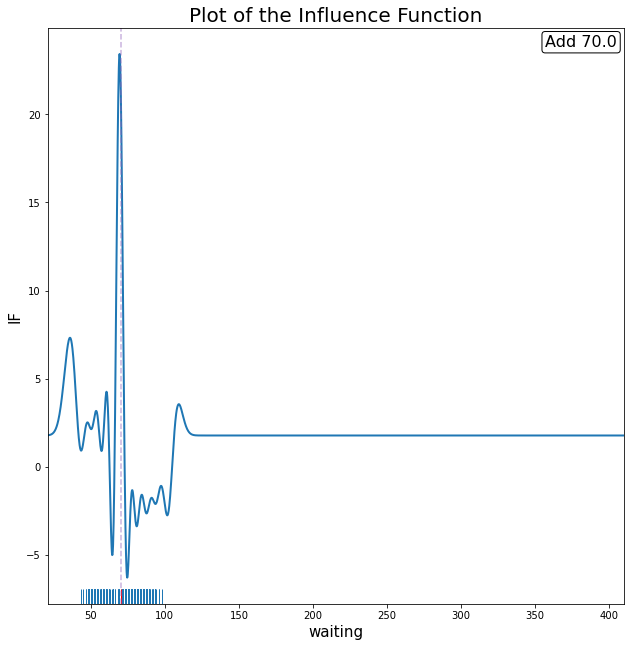

--------------------------------------------------
Current contaminated data point is 61.0.


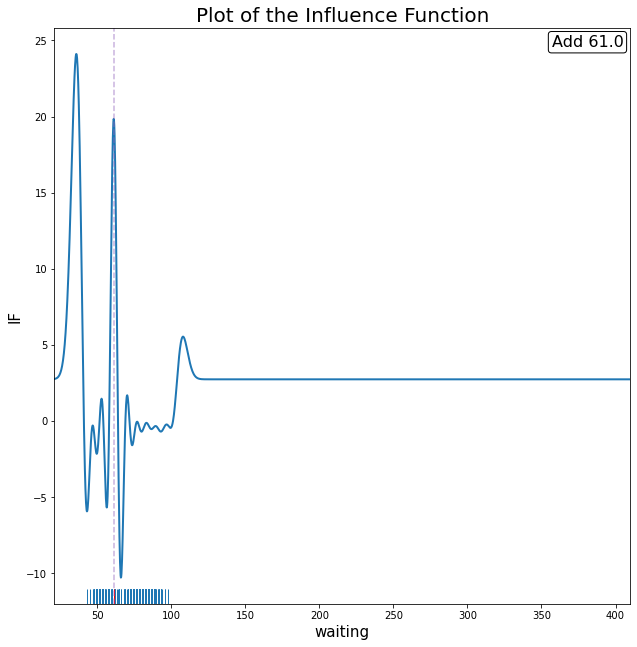

In [10]:
# contaminated data 
contam_data_list = np.array([45., 96., 78., 70., 61.]) # np.arange(., 410., 10)
for contam_pt in contam_data_list: 
    
    print('-' * 50)
    print(f'Current contaminated data point is {contam_pt}.')
    
    contam_data = np.array([[contam_pt]])
    
    ifun = SMInfluenceFunction(
        data = data_waiting, 
        contam_data = contam_data, 
        contam_weight = 1e-8, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density, 
        bw = bw)
    
    if_vals = ifun.plot_IF_logdensity_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    